In [1]:
import os
from thermof.read import read_log, read_thermo
import numpy as np
from wham2d import *
import matplotlib.pyplot as plt
%matplotlib inline

## WHAM 2-D

In [7]:
SCAN = 'DC_Cu110'
SCANDIR = '/home/kutay/Documents/git/Nanocar/surface-scan'
DATADIR = os.path.join(SCANDIR, 'analysis', 'data', SCAN)
WHAMDIR = os.path.join(SCANDIR, 'analysis', 'wham', 'run2d', SCAN)
TSDIR = os.path.join(SCANDIR, 'analysis', 'wham', 'run2d', SCAN, 'data')
os.makedirs(TSDIR, exist_ok=True)
scanlist = [os.path.join(DATADIR, i) for i in os.listdir(DATADIR)]

In [8]:
thermo_headers = 'Step Temp Press TotEng E_pair E_mol Fmax Fnorm c_C1[1] c_C1[2] c_C1[3]'
thermo_keys = ['step', 'temp', 'press', 'etotal', 'epair', 'emol', 'fmax', 'fnorm', 'x', 'y', 'z']

### Write 2D WHAM time series files

In [9]:
K_SPRING = 200                                 # Spring constant in kcal/mol
TIMESTEP = 1                                   # Timstep in femtoseconds
T_CONVERSION = 1e-3                            # femtosecond -> picosecond
T_SKIP = 5                                     # Skip first 5 ps of simulation for WHAM analysis

In [10]:
start_pos = {}
for simdir in scanlist:
    logfile = os.path.join(simdir, 'log.%s' % SCAN)
    try:
        # _, xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        xi, yi = [int(i) for i in os.path.basename(simdir).split('-')]
        thermo_data = read_log(logfile, headers=thermo_headers)
        thermo = read_thermo(thermo_data, headers=thermo_keys)[0]
        # Write time series files
        timeseriesfile = os.path.join(WHAMDIR, 'data', '%i-%i-2d.dat' % (xi ,yi))
        time = timesteps_to_time(thermo['step'], dt=1, conversion=1e-3)  # femtosecond -> picosecond
        time = timesteps_to_time(thermo['step'][T_SKIP:], dt=TIMESTEP, conversion=T_CONVERSION, shift=int(T_SKIP * TIMESTEP))
        write_timeseries_file(timeseriesfile, time, thermo['x'][T_SKIP:], thermo['y'][T_SKIP:])
        for drx in ['x', 'y']:
            # Record starting position (min energy pos)
            start_pos['%i-%i-%s' % (xi ,yi, drx)] = thermo[drx][0]
    except Exception as e:
        print(e, logfile)

### Write 2D WHAM input files

In [11]:
nx, ny = 22, 34
tsfiles, mins_x, mins_y = [], [], []
for ypos in range(ny):
    for xpos in range(nx):
        tsfiles.append(os.path.join(WHAMDIR, 'data', '%i-%i-2d.dat' % (xpos ,ypos)))
        mins_x.append(start_pos['%i-%i-x' % (xpos ,ypos)])
        mins_y.append(start_pos['%i-%i-y' % (xpos ,ypos)])

datafile = os.path.join(WHAMDIR, 'wham-2d.in')
spring_k = [K_SPRING] * len(tsfiles)
write_data_file(datafile, tsfiles, mins_x, mins_y, spring_k, spring_k)

### Run 2D WHAM

In [22]:
hist_min_x, hist_max_x = 21, 26
hist_min_y, hist_max_y = 22, 26
bin_size_x, bin_size_y = 0.2, 0.1
num_bins_x = int(np.ceil((hist_max_x - hist_min_x) / bin_size_x))
num_bins_y = int(np.ceil((hist_max_y - hist_min_y) / bin_size_y))
Px, Py = 'Px=0', 'Py=0'
tolerance = 1e-5
temperature = 200
numpad = 0
use_mask = 0
wham_exec = '/home/kutay/Documents/Research/Software/wham/wham-2d/wham-2d'
outfile = os.path.join(WHAMDIR, 'wham-2d.out')
wham_args = [wham_exec, Px, hist_min_x, hist_max_x, num_bins_x, Py, hist_min_y, hist_max_y, num_bins_y, tolerance, temperature, numpad, datafile, outfile, use_mask]

In [23]:
data = run_wham(wham_args, verbose=False)

### Read WHAM data

In [24]:
xbins = [round(i, 6) for i in np.arange(min(data['x']), max(data['x']) + bin_size_x * 0.5, bin_size_x)]
ybins = [round(i, 6) for i in np.arange(min(data['y']), max(data['y']) + bin_size_y * 0.5, bin_size_y)]
matrixdata = np.zeros((len(xbins), len(ybins)))
probdata = np.zeros((len(xbins), len(ybins)))

In [25]:
for idx, free in enumerate(data['free']):
    x_idx = xbins.index(data['x'][idx])
    y_idx = ybins.index(data['y'][idx])
    matrixdata[x_idx][y_idx] = free
    probdata[x_idx][y_idx] = data['prob'][idx]

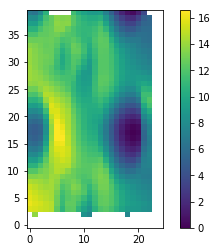

In [26]:
plt.imshow(matrixdata.T, origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(probdata.T, origin='lower', vmax=0.001)
plt.colorbar()

Lets find the min energy pathway in y-direction

In [64]:
all_Ea = []
for yidx in range(num_bins_y - 1):
    Ea = np.array(data['free'][yidx * num_bins_x:(yidx+1) * num_bins_x])
    Ea[np.isinf(Ea)] = 1
    all_Ea.append(max(Ea))
    
T = 200                                # K
kb = 0.0019872041                      # kcal / mol.K
beta = 1 / (kb * T)                    # mol / kcal

all_Ea = np.array(all_Ea)
Ptot = np.exp(-all_Ea * beta)
P = Ptot / Ptot.sum()
print('Min Ea: %.3f | Avg. Ea: %.3f' % (min(all_Ea), (P * all_Ea).sum()))

Min Ea: 11.867 | Avg. Ea: 11.963


In [69]:
max([int(i.split('-')[1]) for i in start_pos.keys()])

34

Save data for surface plot

In [27]:
import yaml

scan_yaml = {'x': data['x'], 'y': data['y'], 'z': data['free']}
SURFDIR = os.path.join(SCANDIR, 'analysis', 'surface-plot')
with open(os.path.join(SURFDIR, '%s-2d-data.yaml' % SCAN), 'w') as yf:
    yaml.dump(scan_yaml, yf)